- Your architecture should consist of a single hidden layer with up to k nodes.
- You can use any activation function (e.g., sigmoid, tanh, etc.) in the hidden nodes.
- Your model must use a bias term at the input and hidden layers. It can be a standalone term or
be incorporated in the weight matrices.
- You should use gradient descent to train your FFNN.
- You may find it helpful to use random number seeds for reproducibility when debugging.
- You do not need to use a GPU for this assignment, and your models should train in less than one
minute each.
- You are responsible for selecting hyperparameters (e.g., number of hidden nodes, learning rate,
training epochs, batch sizes, early stopping criteria, lambda, etc.). The goal is to get “good”
performance from your model, but an exhaustive hyper-parameter search is unnecessary.
- All code, exhibits and answers to free-response questions must be in a single Jupyter notebook.
- Your code should use parameters to control all functionality needed to complete specific tasks
(see below).

In [1]:
import torch

torch.manual_seed(42)

In [2]:
'''
Define model
'''

import torch
import torch.nn as nn
import torch.nn.functional as F

class SingleLayerFFNN(nn.Module):
    def __init__(self, hidden_size, activation_fn="sigmoid", lambda_norm=1e-4, lambda_ortho=1e-4):
        super(SingleLayerFFNN, self).__init__()

        self.input_layer = nn.Linear(2, hidden_size, bias=True)
        # self.output_layer = nn.Linear(hidden_size, 2, bias=True)
        self.output_layer = nn.Linear(hidden_size, 1, bias=True)

        if activation_fn == "sigmoid":
            self.activation = torch.sigmoid
        elif activation_fn == "tanh":
            self.activation = torch.tanh
        elif activation_fn == "relu":
            self.activation = torch.relu

        self.lambda_norm = lambda_norm
        self.lambda_ortho = lambda_ortho

    def forward(self, x):
        # One hidden layer
        hidden = self.activation(self.input_layer(x))
        output = torch.sigmoid(self.output_layer(hidden))

        return output
    
    def compute_regularization(self):
        # first regularizer should minimize the norm of the input layer weight matrix; penalize large input layer weights
        norm_reg = self.lambda_norm * torch.norm(self.input_layer.weight, p="fro")**2

        # second regularizer should encourage orthogonality in the intermediate decision boundaries learned in the first layer
        # => encourage orthogonality = make dot product closr to zero
        weight = self.input_layer.weight
        dot_products = torch.mm(weight, weight.T) # dot_products[i,j] represents the dot prod between ith and jth weight vectors
        identity = torch.eye(dot_products.size(0), device=dot_products.device) # represents the ideal orthogonal case (off-diagonal are 0)
        # identity = torch.eye(dot_products.size(0), device=dot_products.device)

        ortho_reg = self.lambda_ortho * torch.norm(dot_products - identity, p="fro")**2 # compute the deviation of the dot_products from the identity

        return norm_reg + ortho_reg


In [3]:
'''
Train model
'''

import torch.optim as optim

def train_model(model, train_loader, num_epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        # loss for this epoch
        epoch_loss = 0
        for data, target in train_loader:
            target = target.float().unsqueeze(1)
            optimizer.zero_grad() # reset gradients
            output = model(data) # forward pass
            # print(output, target)
            primary_loss = criterion(output, target) # calculate loss
            reg_loss = model.compute_regularization()
            loss = primary_loss + reg_loss
 
            loss.backward() # backpropagation
            optimizer.step() # take step based on gradients and lr

            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

In [4]:
'''
Take in raw csv file path and batch size, return DataLoader object
'''

import csv
import torch
from torch.utils.data import DataLoader, TensorDataset

def load_data(file_path, batch_size):
    inputs = []
    labels = []

    with open(file_path, "r") as csvfile:
        reader = csv.reader(csvfile)
        next(reader) # skip header row
        for row in reader:
            labels.append(float(row[0]))
            inputs.append([float(row[1]), float(row[2])])

    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    dataset = TensorDataset(inputs_tensor, labels_tensor)
    loader = DataLoader(dataset, batch_size=batch_size)

    return loader


In [22]:
'''
Train model with train set. 
Hyperparameters: hidden_size, batch_size, num_epochs, learning_rate
'''

file_path = "xor_train.csv"

# hidden_size from [2, 3, 5, 7, 9] 
hidden_size = 7
batch_size = 32
# activation from "sigmoid", "relu", "tanh"
activation_fn = "relu"
num_epochs = 50
learning_rate = 1
lambda_norm = 0
lambda_orth = 0

train_loader = load_data(file_path, batch_size)
model = SingleLayerFFNN(hidden_size, activation_fn)

train_model(model, train_loader, num_epochs, learning_rate)

Epoch 1/50, Loss: 0.2302
Epoch 2/50, Loss: 0.2143
Epoch 3/50, Loss: 0.2032
Epoch 4/50, Loss: 0.1946
Epoch 5/50, Loss: 0.1879
Epoch 6/50, Loss: 0.1821
Epoch 7/50, Loss: 0.1764
Epoch 8/50, Loss: 0.1688
Epoch 9/50, Loss: 0.1578
Epoch 10/50, Loss: 0.1442
Epoch 11/50, Loss: 0.1292
Epoch 12/50, Loss: 0.1150
Epoch 13/50, Loss: 0.1029
Epoch 14/50, Loss: 0.0932
Epoch 15/50, Loss: 0.0857
Epoch 16/50, Loss: 0.0798
Epoch 17/50, Loss: 0.0750
Epoch 18/50, Loss: 0.0712
Epoch 19/50, Loss: 0.0681
Epoch 20/50, Loss: 0.0654
Epoch 21/50, Loss: 0.0631
Epoch 22/50, Loss: 0.0610
Epoch 23/50, Loss: 0.0593
Epoch 24/50, Loss: 0.0578
Epoch 25/50, Loss: 0.0564
Epoch 26/50, Loss: 0.0553
Epoch 27/50, Loss: 0.0542
Epoch 28/50, Loss: 0.0533
Epoch 29/50, Loss: 0.0524
Epoch 30/50, Loss: 0.0516
Epoch 31/50, Loss: 0.0508
Epoch 32/50, Loss: 0.0501
Epoch 33/50, Loss: 0.0494
Epoch 34/50, Loss: 0.0488
Epoch 35/50, Loss: 0.0482
Epoch 36/50, Loss: 0.0477
Epoch 37/50, Loss: 0.0472
Epoch 38/50, Loss: 0.0467
Epoch 39/50, Loss: 0.

In [23]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            # if output exceeds threshold 0.5, classify as 1
            preds = (output > 0.5).float()
            all_preds.extend(preds.numpy())
            all_targets.extend(target.numpy())

    all_preds = torch.tensor(all_preds).squeeze()
    all_targets = torch.tensor(all_targets)
    
    correct = (all_preds == all_targets).sum().item()
    total = len(all_targets)
    accuracy = correct / total
    
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

In [24]:
eval_file_path = "xor_valid.csv"
eval_batch_size = 4

eval_loader = load_data(eval_file_path, eval_batch_size)
evaluate_model(model, eval_loader)

Accuracy: 0.9550


0.955

In [5]:
import matplotlib.pyplot as plt

def plot_loss_curves(model, train_loader, val_loader, num_epochs, optimizer, criterion):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        running_train_loss = 0.0
        for data, target in train_loader:
            target = target.squeeze()
            optimizer.zero_grad()
            output = model(data).squeeze()
            primary_loss = criterion(output, target)
            reg_loss = model.compute_regularization()
            loss = primary_loss + reg_loss
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation loop
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                target = target.squeeze()
                output = model(data).squeeze()
                loss = criterion(output, target)
                running_val_loss += loss.item()
        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    # Plotting the loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, val_losses


Epoch 1/100 - Train Loss: 0.2444, Validation Loss: 0.2748
Epoch 2/100 - Train Loss: 0.2405, Validation Loss: 0.2679
Epoch 3/100 - Train Loss: 0.2371, Validation Loss: 0.2624
Epoch 4/100 - Train Loss: 0.2341, Validation Loss: 0.2579
Epoch 5/100 - Train Loss: 0.2311, Validation Loss: 0.2539
Epoch 6/100 - Train Loss: 0.2280, Validation Loss: 0.2502
Epoch 7/100 - Train Loss: 0.2248, Validation Loss: 0.2467
Epoch 8/100 - Train Loss: 0.2214, Validation Loss: 0.2434
Epoch 9/100 - Train Loss: 0.2180, Validation Loss: 0.2401
Epoch 10/100 - Train Loss: 0.2145, Validation Loss: 0.2369
Epoch 11/100 - Train Loss: 0.2111, Validation Loss: 0.2337
Epoch 12/100 - Train Loss: 0.2077, Validation Loss: 0.2306
Epoch 13/100 - Train Loss: 0.2043, Validation Loss: 0.2276
Epoch 14/100 - Train Loss: 0.2011, Validation Loss: 0.2247
Epoch 15/100 - Train Loss: 0.1981, Validation Loss: 0.2219
Epoch 16/100 - Train Loss: 0.1952, Validation Loss: 0.2193
Epoch 17/100 - Train Loss: 0.1924, Validation Loss: 0.2168
Epoch 

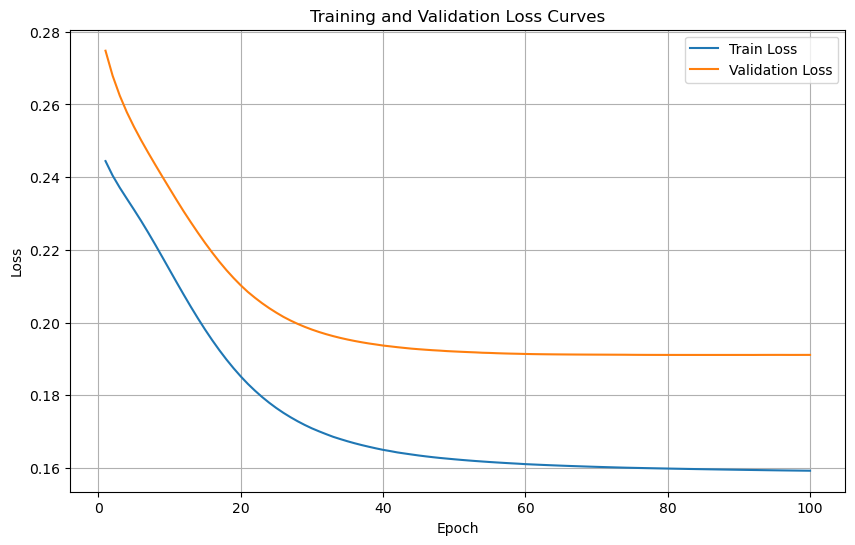

([0.24443259775638582,
  0.2404509675502777,
  0.23712627470493317,
  0.23408440113067627,
  0.23107518911361694,
  0.2279927223920822,
  0.22476142406463623,
  0.22141774654388427,
  0.21797991812229156,
  0.21452231228351593,
  0.21106024742126464,
  0.2076566004753113,
  0.20432958543300628,
  0.20113021194934844,
  0.19806678593158722,
  0.19515916228294372,
  0.1924147742986679,
  0.18984320282936096,
  0.18744807690382004,
  0.18521995723247528,
  0.18316110521554946,
  0.18128791809082032,
  0.17955474704504013,
  0.17796968787908554,
  0.17651715993881226,
  0.17519101858139038,
  0.17398491829633714,
  0.17287346720695496,
  0.1718566831946373,
  0.17092631965875626,
  0.17010604947805405,
  0.16933249354362487,
  0.16859195798635482,
  0.1679709094762802,
  0.16737554877996444,
  0.16682885140180587,
  0.16632623672485353,
  0.16586356490850448,
  0.16542486280202864,
  0.16501423060894013,
  0.1646760630607605,
  0.16431034296751024,
  0.16402062386274338,
  0.16374072432518

In [9]:
file_path = "xor_train.csv"

hidden_size = 3
batch_size = 8
activation_fn = "relu"
num_epochs = 100
learning_rate = 0.1
lambda_norm = 1e-2
lambda_orth = 1e-2

eval_file_path = "xor_valid.csv"
eval_batch_size = 4


train_loader = load_data(file_path, batch_size)
model = SingleLayerFFNN(hidden_size, activation_fn)
eval_loader = load_data(eval_file_path, eval_batch_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

plot_loss_curves(model, train_loader, eval_loader, num_epochs, optimizer, criterion)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


def plot_decision_surface(model, test_loader, feature_range=(-2, 2), resolution=0.01):
    """
    Plots the decision surface of the model along with the test set observations.
    
    Args:
        model: Trained PyTorch model.
        test_loader: DataLoader for the test set.
        feature_range: Tuple (min, max) for the grid of features.
        resolution: Step size for the grid.
    """
    # Generate a grid of points
    x_min, x_max = feature_range
    y_min, y_max = feature_range
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, resolution),
        np.arange(y_min, y_max, resolution)
    )
    
    # Flatten the grid to feed into the model
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32)
    
    # Get model predictions on the grid
    model.eval()
    with torch.no_grad():
        hidden_layer_output = model.activation(model.input_layer(grid_points_tensor)) # hidden layer outputs
        final_output = torch.sigmoid(model.output_layer(hidden_layer_output))
    hidden_layer_outputs = (hidden_layer_output > 0.5).numpy()
    predicted_labels = (final_output > 0.5).float().flatten()
    

    hidden_size = hidden_layer_output.shape[1]
    for i in range(hidden_size):
        Z_hidden = hidden_layer_outputs[:, i].reshape(xx.shape)
        plt.figure(figsize=(8, 6))
        plt.contourf(xx, yy, Z_hidden, levels=50, cmap="coolwarm", alpha=0.6)
        plt.contour(xx, yy, Z_hidden, levels=[0.5], colors="black", linewidths=2, linestyles="--")
        
        # Plot test data points
        for data, target in test_loader:
            data = data.numpy()
            target = target.numpy()
            plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor="k", cmap=plt.cm.coolwarm, s=50)
        
        plt.title(f'Decision Surface of Hidden Neuron {i+1}')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.colorbar(label='Activation Value')
        plt.grid(True)
        plt.show()

    # Plot the final decision surface
    Z_final = predicted_labels.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z_final, levels=50, cmap="coolwarm", alpha=0.6)
    plt.contour(xx, yy, Z_final, levels=[0.5], colors="black", linewidths=2)
    
    # Plot test data points
    for data, target in test_loader:
        data = data.numpy()
        target = target.numpy()
        plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor="k", cmap=plt.cm.coolwarm, s=50)
    
    plt.title('Final Decision Surface')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Prediction Probability')
    plt.grid(True)
    plt.show()

In [ ]:
eval_file_path = "xor_test.csv"
eval_batch_size = 4

test_loader = load_data(eval_file_path, eval_batch_size)
plot_decision_surface(model, test_loader, feature_range=(-4, 4), resolution=0.01)